# The dependence of the CMB power spectrum in cosmological parameters #

We can obtain an approximated description of the CMB spectrum by only looking at the ordinary Sachs-Wolfe effect. That means we will ignore the integrated Sachs-Wolfe effect and contributions from Doppler effects.

Let's start by implementing useful functions. We will use `scipy.integrate.quad` for integration.

In [1]:
from scipy.integrate import quad

To make plots we use `matplotlib` and `ipywidgets` to interact with the plots. In order for that to work we have to set `matplotlib` to `widget` mode.

In [2]:
import matplotlib.pyplot as plt
import ipywidgets as widgets
%matplotlib widget

We use numerical routines implemented in `numpy`

In [3]:
import numpy as np

A nice module that provides a progres bar is `tqdm`

In [4]:
from tqdm import tqdm

First we want to capture the expansion history of the universe in

\begin{equation}
	E(z) = h^{-1} (\omega_{m} (1+z)^{3} + \omega_{r} (1+z)^{4} + \omega_{\Lambda}) ^{1/2}.
\end{equation}

In [5]:
def E(z, h, omega_m, omega_r, omega_l):
    return np.sqrt(omega_m * (1+z)**3 + omega_r * (1+z)**4 + omega_l) / h

With this we can easily express the angular diameter distance in the comoving frame:
    
$$
d_A^c(z) = \frac{1}{H_0} \int_0 ^{z} \frac{dz'}{E(z')} = \frac{c}{2998 \, \mathrm{Mpc} \, h} \int_0 ^{z} \frac{dz'}{E(z')}
$$

In [6]:
def dAc(z, h, omega_m, omega_r, omega_l):
    integral, error = quad(lambda x: 1/E(x, h, omega_m, omega_r, omega_l), 0, z)
    return integral * 2998 / h

Next, we can write the baryon-to-photon ratio as 
$$
R(z) = \frac{3}{4} \frac{\rho_{b}}{\rho_{\gamma}} = \frac{3.04 \times 10^{4}}{1+z} \omega_{b}
$$

In [7]:
def R(z, omega_b):
    return 3.04e4 * omega_b / (1 + z)

With that, the sound speed in plasma (squared) is
$$
c_{s}^{2}(z) = \frac{1}{3} \frac{1}{1 + R(z)}
$$

In [8]:
def cs2(z, omega_b):
    return 1/3 / (1 + R(z, omega_b))

This gives us the sound horizon in the moment of decoupling
$$
r_{s} = H_{0}^{-1} \int _{z_{dec}} ^{\infty} \frac{c_{s}(z)}{E(z)} \, dz
$$

In [9]:
def r_s(z_dec, h, omega_m, omega_r, omega_l, omega_b):
    
    def integrand(z_prime):
        return np.sqrt(cs2(z_prime, omega_b)) / E(z_prime, h, omega_m, omega_r, omega_l)
    
    integral, error = quad(integrand, z_dec, np.inf)
    return integral * 2998 / h

We have seen that the CMB power spectru, arises from the premordial density fluxtuations. 
$$
P_{R}(k) = A_{s}^{2} \left( \frac{k}{k_{p}} \right) ^{n_{s} - 1}
$$

In [10]:
def P_R(k, A_s, k_p, n_s):
    return A_s ** 2 * (k / k_p) ** (n_s - 1)

The CMB power spectrum will be connected to the power spectrum of the premordial density fluctuations. However, this connection is not trivial and the corresponding tramsfer function has to be found empirically.
$$
T(x) = \frac{\ln(1 + 0.171x)}{0.171x} (1 + 0.248x + (1.18x)^{2} + (0.399x)^{3} + (0.490x)^{4}) ^{-1/4}
$$

In [11]:
def T(x):
    return np.log(1 + 0.171*x) / (0.171*x) * (1 + 0.248*x + (1.18*x) ** 2 + (0.399 * x) ** 3 + (0.490 * x) ** 4) ** (-1/4)

Also, as mentioned we can approximate the spherical bessel functions like this:
$$
j_{l}^{2}(x) = 
	\begin{cases}
		\frac{1}{2} \left[ x\sqrt{x^{2} - l^{2}} \right] ^{ -1}, & x>l \\
		0, & x<l
	\end{cases}
$$

In [12]:
def bessel2(x, l):
    if x > l:
        return 0.5 / (x * np.sqrt(x ** 2 - l ** 2))
    else:
        return 0

We have now all the functions to implement the coeffictients for each mutlipole in the CMB power spectrum:
$$
C_{l'} \approx 4 \pi \frac{9}{25} \int P_{R}(k) \left[ -R(z_{dec}) \, T(k/k_{eq}) + \frac{5}{3} \cos (k \, r_{s}) \exp(-k^{2} / k_{D}^{2}) \right]^{2} j_{l'}^{2}(k (\eta_{0} - \eta_{dec})) \frac{dk}{k}
$$

Because we will want to vary $R(z_{dec})$, $r_s$ and $d_A^c(z_{dec})$ independently, we will implement $C_l$ accordingly using the standard values
\begin{align*}
			h &= 0.67 \\
			\omega_{b} &= 0.022 \\
			\omega_{m} &= 0.14 \\
            \omega_r &= 4.17 \times 10^{-5} \\
			n_{s} &= 0.97 \\
            z_{dec} &= 1090.3 \\
            k_D &= 0.14 \, \mathrm{Mpc^{-1}} \\
            k_p &= 0.05  \, \mathrm{Mpc^{-1}} \\
\end{align*}

In [13]:
h_standard = 0.67
omega_b_standard = 0.022
omega_m_standard = 0.14
omega_r_standard = 4.17e-5
omega_l_standard = h_standard**2 - omega_m_standard - omega_r_standard
n_s_standard = 0.97
z_dec_standard = 1090.3
k_D_standard = 0.14     # in 1/Mpc
k_p_standard = 0.05     # in 1/Mpc
A_s_standard = 4.69e-5

In [14]:
def Cl(
    l, 
    R_of_zdec=None, 
    r_s_value=None, 
    dAc_dec=None,
    z_dec=z_dec_standard,
    k_D=k_D_standard, 
    k_p=k_p_standard,
    A_s=A_s_standard,
    n_s=n_s_standard,
    h=h_standard,
    omega_m=omega_m_standard,
    omega_b=omega_b_standard,
    omega_r=omega_r_standard
):
    
    omega_l = h**2 - omega_m - omega_r
    k_eq = 0.073 * omega_m
    
    if R_of_zdec is None:
        R_of_zdec = R(z=z_dec, omega_b=omega_b)
        
    if r_s_value is None:
        r_s_value = r_s(z_dec=z_dec, h=h, omega_m=omega_m, omega_r=omega_r, omega_l=omega_l, omega_b=omega_b)
        
    if dAc_dec is None:
        dAc_dec = dAc(z=z_dec, h=h, omega_m=omega_m, omega_r=omega_r, omega_l=omega_l)
        
    def integrand(k):
        return (
            P_R(k=k, A_s=A_s, k_p=k_p, n_s=n_s) / k * 
            (
                -R_of_zdec * T(x=k/k_eq) 
                + 5/3 * np.cos(k * r_s_value) * np.exp(-k**2/k_D**2)
            ) ** 2 
            * bessel2(k * dAc_dec, l) 
        )
        
    integral, error = quad(integrand, l/dAc_dec, 2000/dAc_dec)
    
    # to (micro Kelvin) ^ 2
    muK_factor = 1e12
    
    return 4*np.pi * 9/25 * integral * muK_factor

The coefficients of the power spectrum are 
$$
l(l+1)C_l / 2\pi
$$

In [15]:
def coeff(l, *args, **kwargs):
    return l * (l + 1) * Cl(l, *args, **kwargs) / (2*np.pi)

`numpy` has a nice utility to make a version of a function that accepts a vector instead of a single float:

In [16]:
vcoeff = np.vectorize(coeff)

## Objective 1:
Fix the values of the parameters of the cosmological standard model
		\begin{align*}
			h &= 0.67 \\
			\omega_{b} &= 0.022 \\
			\omega_{m} &= 0.14 \\
			n_{s} &= 0.97
		\end{align*}
		Calculate $R(z_{dec})$, $r_{s}$ and $d_{A}^{c}(z_{dec})$. Show $l(l+1)C_{l}/(2\pi)$ in a plot for $l = [100, 500]$.

In [17]:
standard_values = {
    "R(zdec)        ": R(z_dec_standard, omega_b_standard), 
    "r_s       [Mpc]": r_s(z_dec_standard, h_standard, omega_m_standard, omega_r_standard, omega_l_standard, omega_b_standard), 
    "dAc(zdec) [Mpc]": dAc(z_dec_standard, h_standard, omega_m_standard, omega_r_standard, omega_l_standard)
}

for k, v in standard_values.items():
    print(f"{k} = {v:.2f}")

R(zdec)         = 0.61
r_s       [Mpc] = 145.33
dAc(zdec) [Mpc] = 14002.47


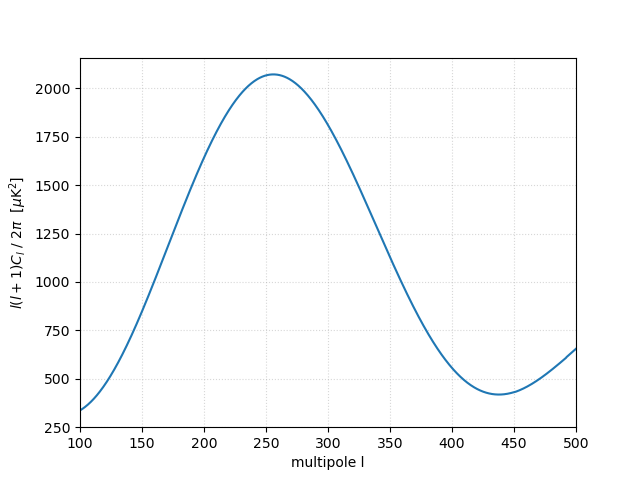

In [18]:
l = np.linspace(100, 500, 1000)

fig, ax = plt.subplots()
ax.plot(l, vcoeff(l))
ax.set_xlabel("multipole l")
ax.set_ylabel("$l(l+1)C_l$ / $2\pi$  [$\mu$K$^2$]")
ax.set_xlim(100, 500)
ax.grid(ls=":", alpha=0.5)
plt.show()

For higher multipoles the result still looks good but becomes increasingly incorrect

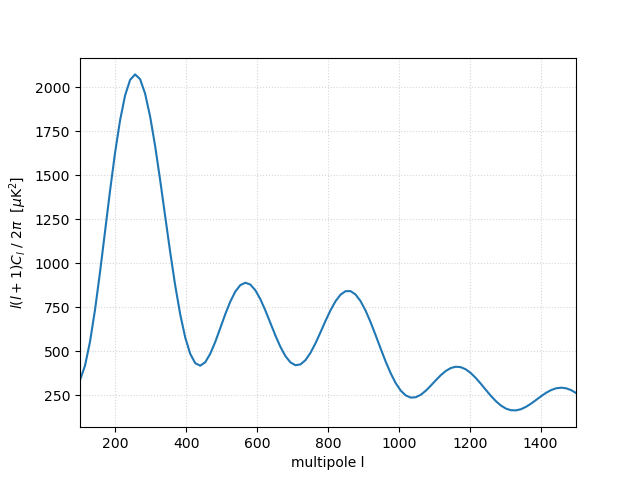

In [19]:
l = np.linspace(100, 1500, 100)

fig, ax = plt.subplots()
ax.plot(l, vcoeff(l))
ax.set_xlabel("multipole l")
ax.set_ylabel("$l(l+1)C_l$ / $2\pi$  [$\mu$K$^2$]")
ax.set_xlim(100, 1500)
ax.grid(ls=":", alpha=0.5)
plt.show()

## Objective 2: ##

Study the dependency of the spectrum on $R(z_{dec})$, $r_{s}$ and $d_{A}^{c}(z_{dec})$ by varying them independently.

(We will actually do something cooler and vary the parameters also dependent on the otehrs)

In [20]:
factors = np.linspace(0.5, 2, 10)
param_factors = [(i, j, k) for i in factors for j in factors for k in factors]
varied_coeff = dict()

for i_factors in tqdm(param_factors):
    iR_zdec = standard_values["R(zdec)        "] * i_factors[0]
    ir_s = standard_values["r_s       [Mpc]"] * i_factors[1]
    idAc_zdec = standard_values["dAc(zdec) [Mpc]"] * i_factors[2]
    varied_coeff[i_factors] = vcoeff(l, R_of_zdec=iR_zdec, r_s_value=ir_s, dAc_dec=idAc_zdec)

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 58.84it/s]


interactive(children=(FloatSlider(value=1.0, description='factor $R(z_{dec})$', max=2.0, min=0.5), FloatSlider…

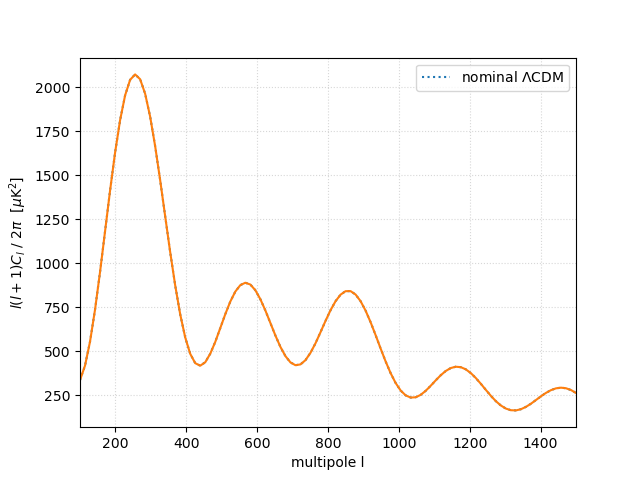

In [28]:
fig, ax = plt.subplots()

ax.plot(l, vcoeff(l), label="nominal $\Lambda$CDM", ls=":")
line, = ax.plot(l, vcoeff(l))
ax.set_xlabel("multipole l")
ax.set_ylabel("$l(l+1)C_l$ / $2\pi$  [$\mu$K$^2$]")
ax.set_xlim(100, 1500)
ax.grid(ls=":", alpha=0.5)
ax.legend()

def update(i, j, k):
    i_factors = np.array([i, j, k])
    D = np.sum((param_factors - i_factors) ** 2, axis=1)
    min_index = np.argmin(D)
    line.set_ydata(varied_coeff[param_factors[min_index]])
    
sliders = [
        widgets.FloatSlider(
        value=1,
        min=0.5,
        max=2,
        step=0.1,
        description=label,
        disabled=False,
        continuous_update=True,
        orientation='horizontal',
        readout=True,
        readout_format='.2f',
    )
    for label in ["factor $R(z_{dec})$", "factor $r_s$", "factor $d^c_A(z_{dec})$"]
]

widgets.interact(update, i=sliders[0], j=sliders[1], k=sliders[2])

plt.show()

Apparently increasing $R(z_{dec})$ increases the even peaks. Remember that it is connected to the energy in baryons at the time of decoupling: $R(z_{dec}) = 3.04 \times 10^{4}(1+z_{dec})^{-1} \omega_{b}$ and that the first peak is the scale that just oscillated once. For more baryons this oscillations becomes stronger. The odd peaks diminish because they represent scales that are maximally stretched out.

Increasing $r_s$ compresses the spectrum because it describes the sound horizon at decoupling. For a bigger sound horizon, larger regions can interact and the the oscillation happens at larger scales (smaller $l$).

An increase in $d_A^c(z_{dec})$ does (almost) not change the amplitude of the peaks but rather their position because it only appears as the proportional constant between scale $k$ and the multipole moment $l$. In this approximation anyway it affects the amplitude a tiny bit because it is used to approximate the integration boundaries in $C_l$.

## Objective 3: ##

Study the dependency of the spectrum on $h$. Apart from the standard value, consider $h=0.5$ and $h=0.8$ with all other parameters fixed. Convince yourself that varying $h$ does not affect the amplitude of the peaks but rather their position. Explain this behavior in terms of the effects seen in Objective 2.

Same as before, let's pre-calculate some values and interactively plot them.

In [22]:
h_values = np.linspace(0.5, 0.8, 100)
varied_coeff_h = {ih: vcoeff(l, h=ih) for ih in tqdm(h_values)}

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 11.28it/s]


interactive(children=(FloatSlider(value=0.67, description='h', max=0.8, min=0.5, step=0.01), Output()), _dom_c…

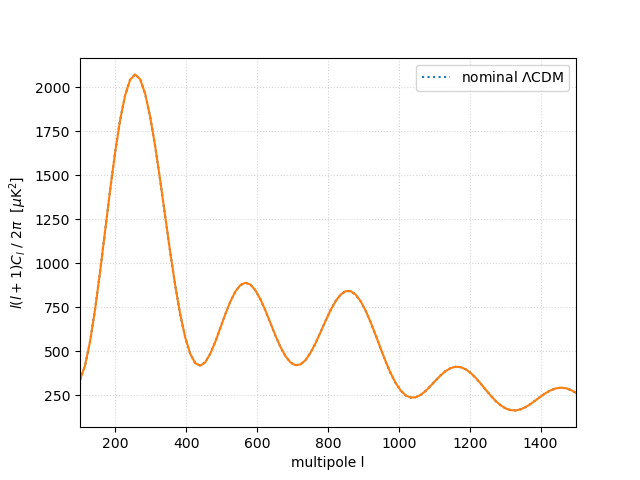

In [35]:
fig, ax = plt.subplots()

ax.plot(l, vcoeff(l), label="nominal $\Lambda$CDM", ls=":")
hline, = ax.plot(l, vcoeff(l))
ax.set_xlabel("multipole l")
ax.set_ylabel("$l(l+1)C_l$ / $2\pi$  [$\mu$K$^2$]")
ax.set_xlim(100, 1500)
ax.grid(ls=":", alpha=0.5)
ax.legend()

def update(ih):
    D = (ih - h_values) ** 2
    min_index = np.argmin(D)
    hline.set_ydata(varied_coeff_h[h_values[min_index]])
    
hslider = widgets.FloatSlider(
            value=h_standard,
            min=min(h_values),
            max=max(h_values),
            step=0.01,
            description="h",
            disabled=False,
            continuous_update=True,
            orientation='horizontal',
            readout=True,
            readout_format='.2f',
)

widgets.interact(update, ih=hslider)

plt.show()

Varying $h$ changes $E(z) = h^{-1}(\omega_m (1+z)^3 + \omega_r (1+z)^4 + \omega _{\Lambda})^{1/2}$ which affects
$$ d_A^c(z_{dec}) = H_0 ^{-1}  \int _0 ^{z_{dec}} \frac{dz}{E(z)} $$. Because of $\omega_{\Lambda} = h^2 - \omega_m - \omega_r$, increasing $h$ will increase $\omega_{\Lambda}$ which will increse $E(z)$. That will finally decrease $d_A^c(z_{dec})$ which leads to a stretch of the spectrum as discussed.

Note that also
$$ r_s = H_0^{-1} \int _{z_{dec}} ^{\infty} \frac{c_s(z)}{E(z)}dz $$
will depend on $h$ but since the effect on $E(z)$ is only strong for small $z$ and the integral starts at $z_{dec}=1090$, changing $h$ will not play a role for $r_s$.

## Objective 4: ##

Study the dependency of the spectrum on $\omega_{b}$. Apart from the standard value, consider $\omega_{b}= 0.01$ and $\omega_{b} = 0.04$ with all other parameters fixed. Convince yourself that varying $\omega_{b}$ diminishes the evenly numbered peaks while it increases the odd ones. Explain this behavior in terms of the effects seen in 2.

In [24]:
omega_b_values = np.linspace(0.01, 0.04, 100)
varied_coeff_omega_b = {iwb: vcoeff(l, omega_b=iwb) for iwb in tqdm(omega_b_values)}

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 11.09it/s]


interactive(children=(FloatSlider(value=0.022, description='$\\omega_b$', max=0.04, min=0.01, readout_format='…

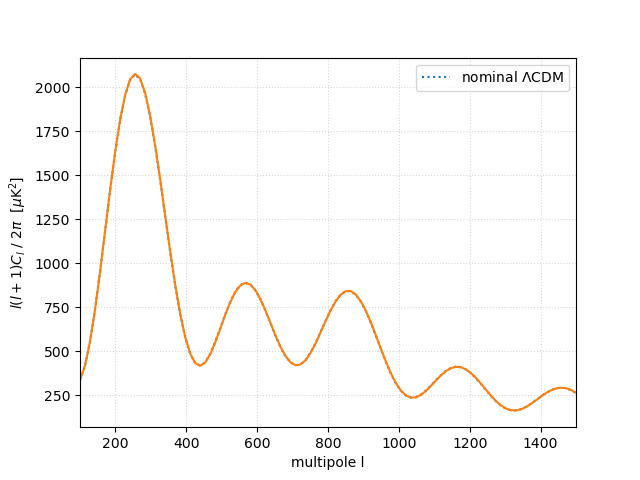

In [36]:
fig, ax = plt.subplots()

ax.plot(l, vcoeff(l), label="nominal $\Lambda$CDM", ls=":")
hline, = ax.plot(l, vcoeff(l))
ax.set_xlabel("multipole l")
ax.set_ylabel("$l(l+1)C_l$ / $2\pi$  [$\mu$K$^2$]")
ax.set_xlim(100, 1500)
ax.grid(ls=":", alpha=0.5)
ax.legend()

def update(iwb):
    D = (iwb - omega_b_values) ** 2
    min_index = np.argmin(D)
    hline.set_ydata(varied_coeff_omega_b[omega_b_values[min_index]])
    
hslider = widgets.FloatSlider(
            value=omega_b_standard,
            min=min(omega_b_values),
            max=max(omega_b_values),
            step=0.001,
            description="$\omega_b$",
            disabled=False,
            continuous_update=True,
            orientation='horizontal',
            readout=True,
            readout_format='.3f',
)

widgets.interact(update, iwb=hslider)

plt.show()

Remember that $R(z_{dec}) \propto \omega_b$ and we have explained the dependence on $R(z_{dec})$ above.

## Objective 5: ##

Study the dependency of the spectrum on $n_{s}$. Apart from the standard value, consider $n_{s} = 0.7$ and $n_{s} = 1.2$ with all other parameters fixed. Show the corresponding value of $l$ for the pivot scale $k_{p}$ in your plot and explain the behavior.

In [26]:
ns_values = np.linspace(0.7, 1.2, 100)
vary_coeff_ns = {ins: vcoeff(l, n_s=ins) for ins in tqdm(ns_values)}

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 11.39it/s]


interactive(children=(FloatSlider(value=0.7, description='$n_s$', max=1.2, min=0.7, readout_format='.3f', step…

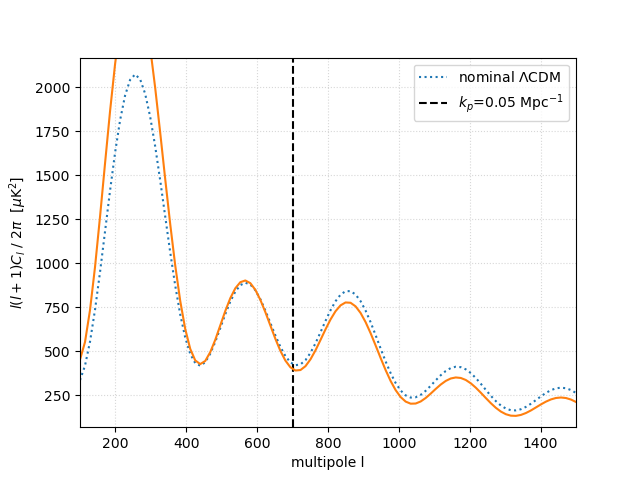

In [37]:
fig, ax = plt.subplots()

ax.plot(l, vcoeff(l), label="nominal $\Lambda$CDM", ls=":")
dAc_standard = dAc(
    z_dec_standard, 
    h=h_standard, 
    omega_m=omega_m_standard,
    omega_l=omega_l_standard, 
    omega_r=omega_r_standard
)
ax.axvline(
    k_p_standard * dAc_standard, 
    ls="--", label=f"$k_p$={k_p_standard:.2f} Mpc$^{ {-1} }$", color="k"
)
hline, = ax.plot(l, vcoeff(l))
ax.set_xlabel("multipole l")
ax.set_ylabel("$l(l+1)C_l$ / $2\pi$  [$\mu$K$^2$]")
ax.set_xlim(100, 1500)
ax.grid(ls=":", alpha=0.5)
ax.legend()

def update(ins):
    D = (ins - ns_values) ** 2
    min_index = np.argmin(D)
    hline.set_ydata(vary_coeff_ns[ns_values[min_index]])
    
hslider = widgets.FloatSlider(
            value=omega_b_standard,
            min=min(ns_values),
            max=max(ns_values),
            step=0.01,
            description="$n_s$",
            disabled=False,
            continuous_update=True,
            orientation='horizontal',
            readout=True,
            readout_format='.3f',
)

widgets.interact(update, ins=hslider)

plt.show()

Because of $P_R(k) = A_s^2 (k/k_p)^{n_s - 1}$, fluctuations on scales below $k_p$ will decrease and vice versa for $n_s>1$ (and vice versa).